In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

In [51]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [52]:
import fastai
fastai.defaults.device = torch.device('cpu')

In [53]:
from fastai.callbacks import *

In [54]:
import myutils as my

In [55]:
def create_head_sigmoid(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5):
    """Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes.
    :param ps: dropout, can be a single float or a list for each layer."""
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.Sigmoid()] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    del(layers[-3])
    return nn.Sequential(*layers)

In [56]:
path = Path('data/mnist_png/')
classes = list(range(8))
head = create_head_sigmoid(1024,8,lin_ftrs=[128])

In [57]:
tfms = get_transforms(do_flip=False)
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=tfms, size=26)

In [58]:
learner = create_cnn(data2, models.resnet18, custom_head=head).load('test128')

In [59]:
flatten_model(learner.model)[-1].out_features

8

In [60]:
class StoreHook(Callback):
    def __init__(self, module):
        super().__init__()
        self.custom_hook = hook_output(module)
        self.outputs = []
        
    def on_batch_end(self, train, **kwargs): 
        if (not train): self.outputs.append(self.custom_hook.stored.numpy())

In [61]:
nn_module = learner.model[-1][-3]
learner.callbacks = [ StoreHook(nn_module) ]

In [62]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=128, bias=True)
  (5): Sigmoid()
  (6): Dropout(p=0.5)
  (7): Linear(in_features=128, out_features=8, bias=True)
)

In [63]:
nn_module

Sigmoid()

In [64]:
for i in (path/'9').iterdir():
    print(i)

data/mnist_png/9/22.png
data/mnist_png/9/48.png
data/mnist_png/9/4.png
data/mnist_png/9/428.png
data/mnist_png/9/15357.png
data/mnist_png/9/14667.png
data/mnist_png/9/14743.png
data/mnist_png/9/764.png
data/mnist_png/9/14443.png
data/mnist_png/9/14580.png
data/mnist_png/9/78.png
data/mnist_png/9/14364.png
data/mnist_png/9/14607.png
data/mnist_png/9/33.png
data/mnist_png/9/116.png
data/mnist_png/9/14336.png
data/mnist_png/9/800.png
data/mnist_png/9/15541.png
data/mnist_png/9/14735.png
data/mnist_png/9/15592.png
data/mnist_png/9/601.png
data/mnist_png/9/14680.png
data/mnist_png/9/176.png
data/mnist_png/9/15128.png
data/mnist_png/9/227.png
data/mnist_png/9/15560.png
data/mnist_png/9/14341.png
data/mnist_png/9/15089.png
data/mnist_png/9/15360.png
data/mnist_png/9/14662.png
data/mnist_png/9/15395.png
data/mnist_png/9/15381.png
data/mnist_png/9/14922.png
data/mnist_png/9/15302.png
data/mnist_png/9/383.png
data/mnist_png/9/15562.png
data/mnist_png/9/14984.png
data/mnist_png/9/282.png
data/mni

In [65]:
def convert_np(arr):
    size = arr[0].shape[1]
    ref = np.array([], dtype=np.int64).reshape(0,size)
    for row in arr:
        ref = np.vstack([ref, row])
    return ref

In [66]:
def run_folder(path, Learner):
    for i in (path).iterdir():
        print(i)
        Learner.predict(open_image(i))

In [67]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

In [68]:
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return np.log(p.pdf(dataset))

In [69]:
def selectThresholdByCV(probs,gt):
    set_trace()
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

In [70]:
def get_lst_folder(folder):
    lst_9cv = list((path/folder).iterdir())
    gt = [1]*len(lst_9cv)
    return lst_9cv, gt

In [71]:
fraud_cls = ['0','1','2','3','4','5','6','7','8']

In [72]:
def run_folder(path, Learner):
    for i in (path).iterdir():
        Learner.predict(open_image(i))

In [73]:
def run_lst(lst, Learner):
    for i in lst:
        Learner.predict(open_image(i))

In [74]:
def get_lst_cls(cv_cls, nb = 2):
    lst_fr = []
    gt = []
    for cls in cv_cls:
        folder = (path/cls).iterdir()
        for i in range(nb):
            lst_fr.append(next(folder))
    gt = [0]*len(lst_fr)
    return lst_fr, gt
        

In [75]:
learner.callbacks[0].outputs = []
run_folder(path/'9', learner)
ref = convert_np(learner.callbacks[0].outputs)

In [76]:
mu, sigma = estimateGaussian(ref)
p = multivariateGaussian(ref,mu,sigma)


In [77]:
np.mean(p)

208.20734995331932

Mean: -74.03641732008869
Min: -577.9796300634257 Max: 126.28742355517446


Text(0.5,1,'Histogram')

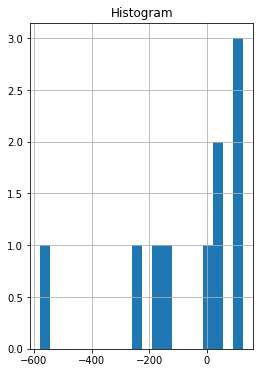

In [89]:
learner.callbacks[0].outputs = []
run_folder(path/'7', learner)
ref_fraud = convert_np(learner.callbacks[0].outputs)
p_fr = multivariateGaussian(ref_fraud,mu,sigma)
print('Mean: ' + str(np.mean(p_fr)))
print('Min: ' + str(min(p_fr)) + ' Max: ' + str(max(p_fr)))
pd.DataFrame(p_fr).hist(figsize=(4,6), bins=20);
plt.title('Histogram')

In [92]:
p_fr

array([  27.281047,    6.663944,  221.086625,  203.334476,  204.530992,  186.217571,  104.086783,  195.818645,
       -359.858034,    9.330117,  127.373503,  127.694818, -377.558826,   41.449965,  231.983258,  179.755308,
        -10.747576, -107.443529,  176.383797,  206.172116,  206.250682, -161.254825,   85.531938,  208.677114,
        173.531244,  222.332594,  172.103537, -441.635038,  139.798238,  118.047392,  216.09183 ,   47.037239,
        131.93425 ,  156.705587,   -4.539612,   26.622492,  109.605973,  117.494171,        -inf, -363.872647])

208.20734995331932
153.84419495104507 254.7009888101207


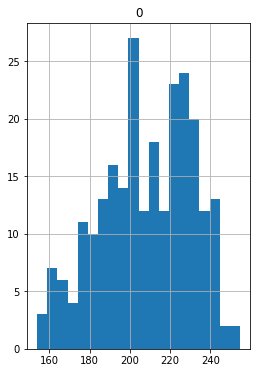

In [93]:
learner.callbacks[0].outputs = []
run_folder(path/'9', learner)
ref_fraud = convert_np(learner.callbacks[0].outputs)
p_fr = multivariateGaussian(ref_fraud,mu,sigma)
print(np.mean(p_fr))
print(min(p_fr),max(p_fr))

pd.DataFrame(p_fr).hist(stacked=False,figsize=(4,6), bins=20);